In [81]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import lsst.daf.base as dafBase
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask

%matplotlib inline

In [4]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal_2/"
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_daytest/"

In [49]:
directory = DATADIR+"/jointcal_test_mini_2/"
butler = dafPersist.Butler(directory) 

In [50]:
deepCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":"15,15"})
dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":"15,15", 'date':"2006-05-20"})



In [193]:
def detect_sources(exposure, th=10):
    threshold = th
    doSmooth=True
    schema = afwTable.SourceTable.makeMinimalSchema()


    algMetadata = dafBase.PropertyList()

    config = SourceDetectionTask.ConfigClass()
    #config.thresholdPolarity = "both"
    config.thresholdValue = threshold
    config.reEstimateBackground = False
    #config.thresholdType = "pixel_stdev"

    detectionTask = SourceDetectionTask(config=config, schema=schema)

    measurement = SingleFrameMeasurementTask
    
    config = SingleFrameMeasurementTask.ConfigClass()
    #config.plugins.names.clear()
    #config.plugins.names.add("base_ClassificationExtendedness")

    measurement = measurement(schema, config=config, algMetadata=algMetadata)


    deblend = SourceDeblendTask
    config = SourceDeblendTask.ConfigClass()
    deblend = deblend(schema)

    table = afwTable.SourceTable.make(schema)
    
    results = detectionTask.run(table=table, exposure=exposure , doSmooth=doSmooth )

    sourcesCat = results.sources
    
    deblend.run(exposure, sourcesCat)
    
    

    measurement.run(measCat=sourcesCat, exposure=exposure)

    return sourcesCat

def show_image_and_sources(exposure, sources=None):

    plt.figure(figsize=(10,10))

    arrImage = exposure.getMaskedImage().getImage().getArray()

    plt.imshow(arrImage, cmap="gray", vmin = np.mean(arrImage)-np.std(arrImage), vmax= np.mean(arrImage)+np.std(arrImage))
    wcs = deepCoadd.getWcs()

    if sources is not None:
        for src in sources:
            x, y = wcs.skyToPixel(src["coord_ra"],src["coord_dec"])
            print x, y
            print x-exposure.getX0(), y-exposure.getY0()
            plt.plot(x-exposure.getX0(), y-exposure.getY0(), "r+", markersize=15)
    plt.xlim(xmin=0, xmax=exposure.getWidth())
    plt.ylim(ymin=0, ymax=exposure.getHeight())
    plt.show()

In [116]:
deepCoadd.getX0()

14900L

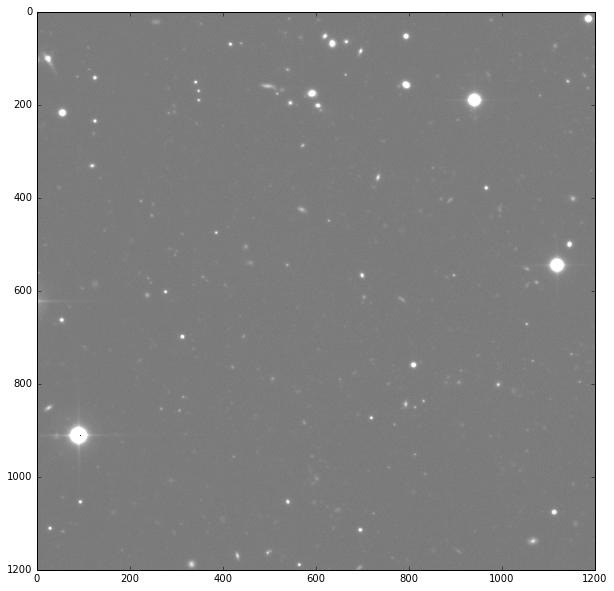

In [51]:
plt.figure(figsize=(10,10))

arrImage = deepCoadd.getMaskedImage().getImage().getArray()

plt.imshow(arrImage, cmap="gray", vmin = np.mean(arrImage)-np.std(arrImage), vmax= np.mean(arrImage)+np.std(arrImage))
plt.show()

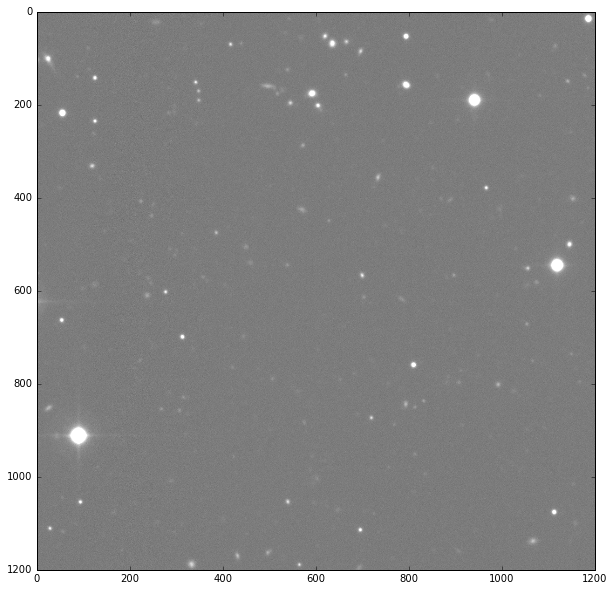

In [52]:
plt.figure(figsize=(10,10))

arrImage = dayCoadd.getMaskedImage().getImage().getArray()

plt.imshow(arrImage, cmap="gray", vmin = np.mean(arrImage)-np.std(arrImage), vmax= np.mean(arrImage)+np.std(arrImage))
plt.show()

In [53]:
from lsst.pipe.tasks.imageDifference import ImageDifferenceTask

config = ImageDifferenceTask.ConfigClass()


#config.thresholdPolarity = "both"
#config.thresholdValue = threshold
#config.reEstimateBackground = False
#config.thresholdType = "pixel_stdev"

differenceTask = ImageDifferenceTask(config=config)

#measurement = SingleFrameMeasurementTask
    

#imageDifferenceTask = 

In [55]:
import lsst.afw.geom as afwGeom
from lsst.meas.algorithms import SourceDetectionTask, PsfAttributes, SingleGaussianPsf, ObjectSizeStarSelectorTask
from lsst.ip.diffim import ImagePsfMatchTask

In [146]:
subtractedExposure = None
subtractRes = None
selectSources = None
kernelSources = None
controlSources = None
diaSources = None

exposure = dayCoadd
templateExposure = deepCoadd
templateSources = None
sciencePsf = exposure.getPsf()


subtract = ImagePsfMatchTask()
subtract.config.kernel.name="AL"
subtract.config.kernel.active.fitForBackground = True
subtract.config.kernel.active.spatialKernelOrder = 1
subtract.config.kernel.active.spatialBgOrder = 0


ctr = afwGeom.Box2D(exposure.getBBox()).getCenter()
psfAttr = PsfAttributes(sciencePsf, afwGeom.Point2I(ctr))
scienceSigmaOrig = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)

ctr = afwGeom.Box2D(templateExposure.getBBox()).getCenter()
psfAttr = PsfAttributes(templateExposure.getPsf(), afwGeom.Point2I(ctr))
templateSigma = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)

scienceSigmaPost = scienceSigmaOrig

subtractRes = subtract.subtractExposures(
                templateExposure=templateExposure,
                scienceExposure=exposure,
                candidateList=kernelSources,
                convolveTemplate=True,
                doWarping=False
            )
subtractedExposure = subtractRes.subtractedExposure



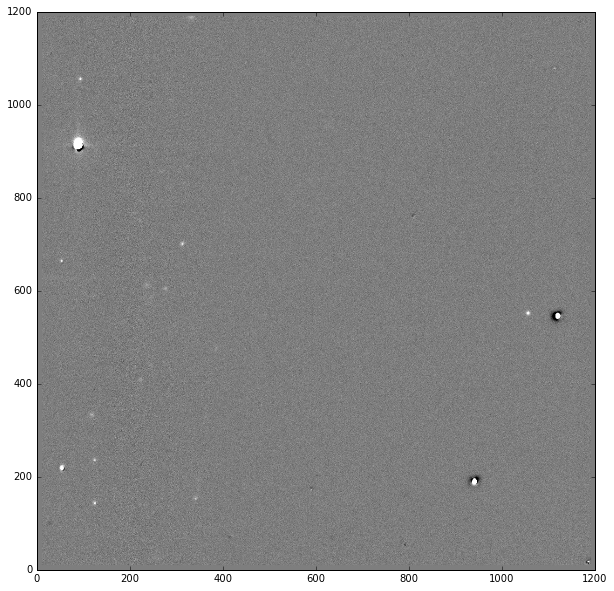

In [109]:
plt.figure(figsize=(10,10))
f = 0
arrImage = subtractedExposure.getMaskedImage().getImage().getArray()
arrImage=np.nan_to_num(arrImage)
arrImage=arrImage[f:1200-f,f:1200-f]
plt.imshow(arrImage, cmap="gray", vmin = np.mean(arrImage)-np.std(arrImage), vmax= np.mean(arrImage)+np.std(arrImage), origin ="lower")
plt.show()

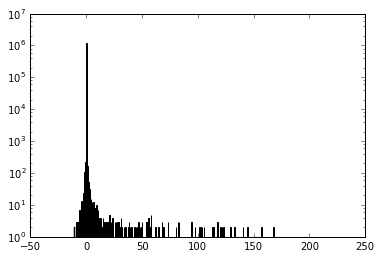

In [79]:
plt.hist(arrImage.ravel(), log=True, bins=500)
plt.show()

In [66]:
max(arrImage.ravel())

243.42572

In [130]:
srcs = detect_sources(deepCoadd)
day_srcs = detect_sources(dayCoadd)

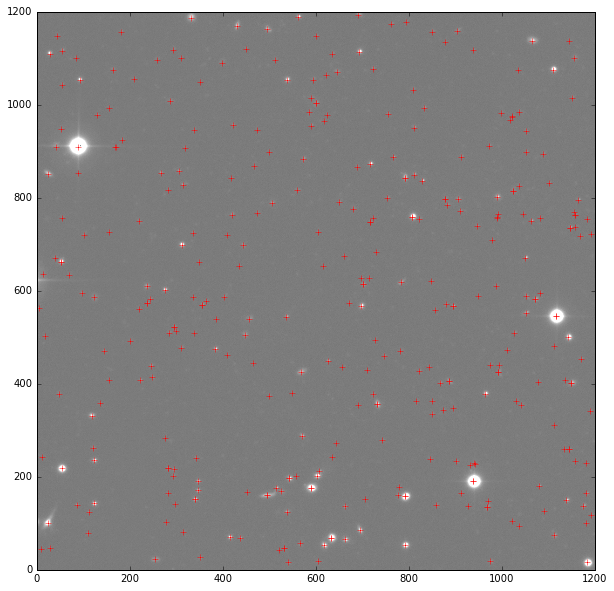

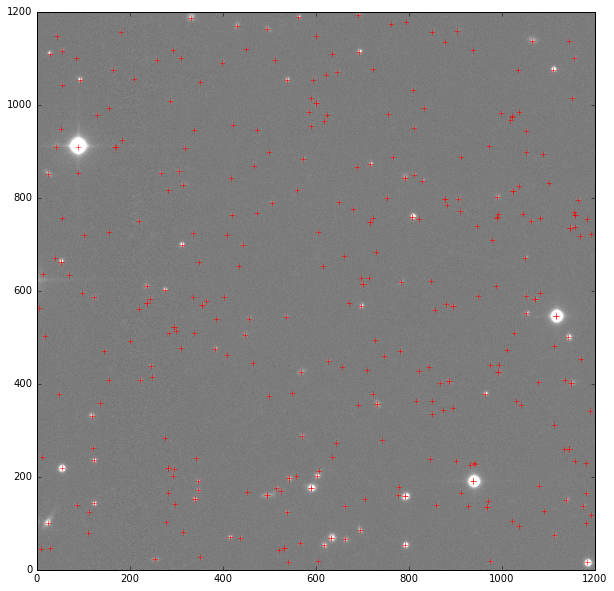

In [131]:
show_image_and_sources(deepCoadd, sources=srcs)
show_image_and_sources(dayCoadd, sources=srcs)

In [491]:
wcs = deepCoadd.getWcs()
s = srcs[200]

x, y = wcs.skyToPixel(s["coord_ra"], s["coord_dec"])
print x, y
print s["coord_ra"], s["coord_dec"]

15952.2430733 15798.7448955
3.74721 rad 0.921086 rad


In [514]:
begin = afwGeom.Point2I(x-20, y-20)
end = afwGeom.Point2I(x+20, y+20)

box = afwGeom.Box2I(begin, end)

deep_patch = deepCoadd.Factory(deepCoadd, box, deep=True)
day_patch = deepCoadd.Factory(dayCoadd, box, deep=True)

In [515]:
deep_srcs = detect_sources(deep_patch, th=2)
day_srcs = detect_sources(day_patch, th=2)
print len(deep_srcs), len(day_srcs)

5 1


In [516]:
print deep_patch.getX0(), deep_patch.getY0()

#14928.7001766 14947.7372445
#3.74816 rad 0.920345 rad

15932 15778


In [517]:
print deep_srcs[0]["coord_ra"], deep_srcs[0]["coord_dec"]
print day_srcs[0]["coord_ra"], day_srcs[0]["coord_dec"]

3.74723 rad 0.921076 rad
3.74721 rad 0.921086 rad


15938.0 15787.0
5.99999999986 8.99999999964
15952.0 15799.0
20.0000000001 21.0
15952.0 15799.0
20.0000000001 21.0
15964.0 15797.0
32.0 18.9999999999
15966.0 15784.0
34.0 5.99999999986


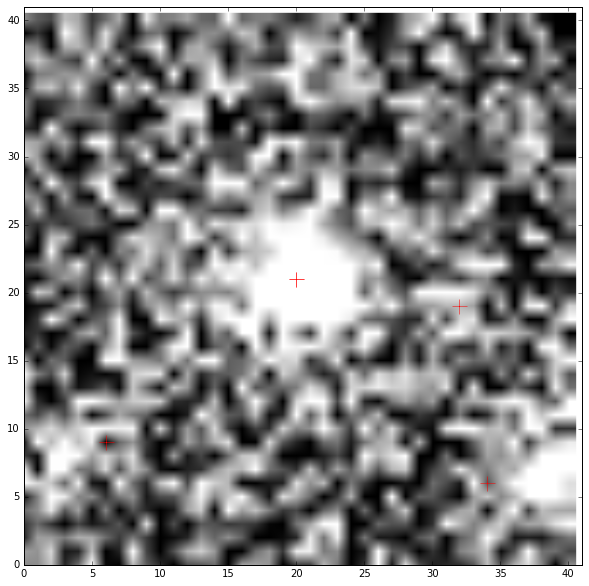

15951.0 15798.0
18.9999999999 20.0


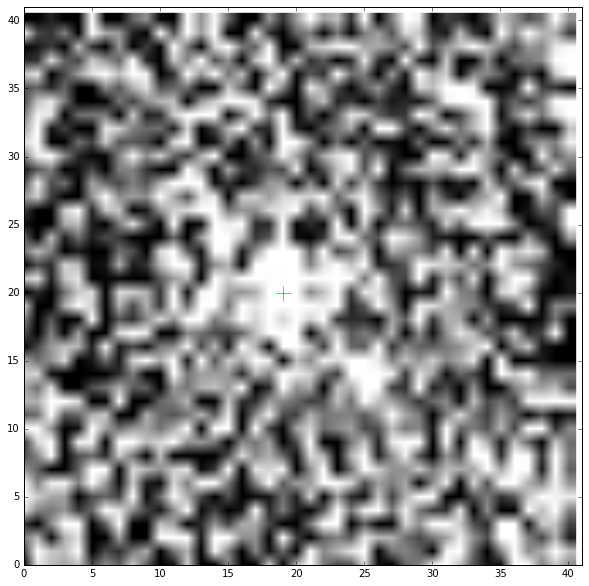

In [518]:
show_image_and_sources(deep_patch, sources=deep_srcs)
show_image_and_sources(day_patch, sources=day_srcs)

In [519]:
subtractedExposure = None
subtractRes = None

selectSources = deep_srcs
kernelSources = day_srcs
controlSources = day_srcs

diaSources = None

exposure = day_patch
templateExposure = deep_patch
templateSources = deep_srcs

sciencePsf = exposure.getPsf()


subtract = ImagePsfMatchTask()
subtract.config.kernel.name="AL"
subtract.config.kernel.active.fitForBackground = True
subtract.config.kernel.active.spatialKernelOrder = 4
subtract.config.kernel.active.spatialBgOrder = 0
subtract.config.selectDetection.thresholdValue=5.0

ctr = afwGeom.Box2D(exposure.getBBox()).getCenter()
psfAttr = PsfAttributes(sciencePsf, afwGeom.Point2I(ctr))
scienceSigmaOrig = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)

ctr = afwGeom.Box2D(templateExposure.getBBox()).getCenter()
psfAttr = PsfAttributes(templateExposure.getPsf(), afwGeom.Point2I(ctr))
templateSigma = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)

scienceSigmaPost = scienceSigmaOrig

subtract.kConfig.detectionConfig.scaleByFwhm=True
subtract.kConfig.detectionConfig.detThreshold=3
subtract.kConfig.detectionConfig.fpGrowPix=10

subtractRes = subtract.subtractExposures(
                templateExposure=templateExposure,
                scienceExposure=exposure,
                candidateList=kernelSources,
                convolveTemplate=True,
                doWarping=False
            )
subtractedExposure = subtractRes.subtractedExposure


RuntimeError: Cannot find any objects suitable for KernelCandidacy

15869.0 15731.0
17.0000000003 33.0000000002
16029.7266922 15721.9107691
177.726692213 23.9107691183
15890.0 15735.0
38.0000000001 36.9999999999
15890.0 15704.0
37.9999999997 5.99999999971
15986.3897973 15738.4217645
134.389797277 40.4217645098
15919.4582663 15741.0019333
67.4582662923 43.0019333135
16003.0 15715.0
151.0 17.0
16040.0 15750.0
188.0 51.9999999999
15965.100286 15758.8041497
113.100285965 60.8041496609
15881.0 15777.0
29.0000000001 79.0
15937.5584415 15759.7770634
85.558441485 61.7770634401
16046.0 15769.0
194.0 71.0000000001
15996.3929559 15772.449643
144.39295588 74.4496429549
15927.4503007 15771.8722638
75.4503007248 73.8722637928
16032.0 15777.0
180.0 78.9999999999
15860.0 15790.0
7.9999999999 91.9999999995
15935.0771254 15785.9153445
83.077125439 87.9153444901
15988.932052 15793.9973387
136.93205198 95.9973386625
15916.1347398 15802.0365364
64.1347398081 104.036536374
15873.0 15812.0
20.9999999998 114.0
15974.2012272 15805.6270505
122.201227224 107.627050538
16037.0 15

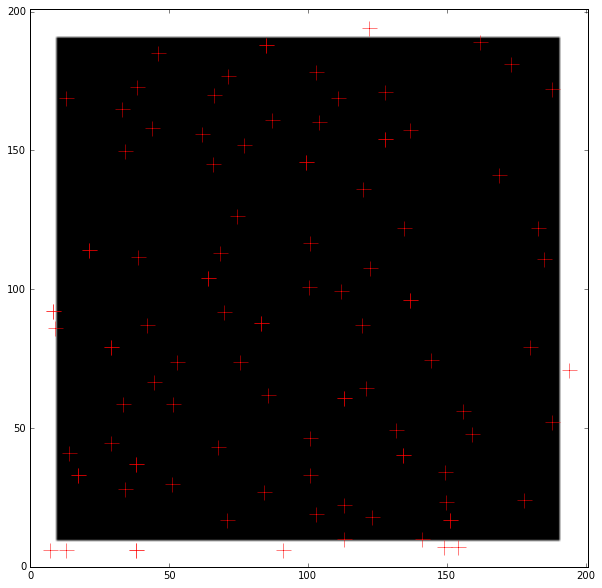

In [499]:
show_image_and_sources(subtractedExposure, sources=deep_srcs)

In [249]:
import lsst.ip.diffim as diffimLib
import lsst.afw.image as afwImage
import lsst.afw.detection as afwDetect
from lsst.ip.diffim.makeKernelBasisList import makeKernelBasisList

In [402]:
scienceExposure = day_patch
dConfig = subtract.kConfig.detectionConfig
templateExposure=deep_patch

candidateInList = kernelSources
candidateOutList = []
fsb = diffimLib.FindSetBitsU()
badBitMask = 0

dConfig.fpGrowPix=10

for mp in dConfig.badMaskPlanes:
    badBitMask |= afwImage.MaskU.getPlaneBitMask(mp)
    bbox = scienceExposure.getBBox()
    
if dConfig.scaleByFwhm:
    print "growing"
    fpGrowPix = int(dConfig.fpGrowKernelScaling * kernelSize + 0.5)
else:
    fpGrowPix = dConfig.fpGrowPix
    print "notGrowing ", fpGrowPix

for kernelCandidate in candidateInList:
    if not type(kernelCandidate) == afwTable.SourceRecord:
        raise RuntimeError("Candiate not of type afwTable.SourceRecord")
    bm1 = 0
    bm2 = 0
    center = afwGeom.Point2I(scienceExposure.getWcs().skyToPixel(kernelCandidate.getCoord()))
    if center[0] < bbox.getMinX() or center[0] > bbox.getMaxX():
        continue
    if center[1] < bbox.getMinY() or center[1] > bbox.getMaxY():
        continue

    xmin = center[0] - fpGrowPix
    xmax = center[0] + fpGrowPix
    ymin = center[1] - fpGrowPix
    ymax = center[1] + fpGrowPix
    
    if (xmin - bbox.getMinX()) < 0:
        xmax += (xmin - bbox.getMinX())
        xmin -= (xmin - bbox.getMinX())
    if (ymin - bbox.getMinY()) < 0:
        ymax += (ymin - bbox.getMinY())
        ymin -= (ymin - bbox.getMinY())
    if (bbox.getMaxX() - xmax) < 0:
        xmin -= (bbox.getMaxX() - xmax)
        xmax += (bbox.getMaxX() - xmax)
    if (bbox.getMaxY() - ymax) < 0:
        ymin -= (bbox.getMaxY() - ymax)
        ymax += (bbox.getMaxY() - ymax)
    if xmin > xmax or ymin > ymax:
        continue


    kbbox = afwGeom.Box2I(afwGeom.Point2I(xmin, ymin), afwGeom.Point2I(xmax, ymax))
    print kbbox
    try:
        fsb.apply(afwImage.MaskedImageF(templateExposure.getMaskedImage(), kbbox, deep=False).getMask())
        bm1 = fsb.getBits()
        print bm1
        fsb.apply(afwImage.MaskedImageF(scienceExposure.getMaskedImage(), kbbox, deep=False).getMask())
        bm2 = fsb.getBits()
        print bm2
    except Exception:
        print "exception"
        pass
    else:
        print (bm1 & badBitMask)==True
        print (bm2 & badBitMask)==True
        if not((bm1 & badBitMask) or (bm2 & badBitMask)):
            candidateOutList.append({'source': kernelCandidate,
                                     'footprint': afwDetect.Footprint(afwGeom.SpanSet(kbbox))})


notGrowing  10
(minimum=(15305, 14961), maximum=(15325, 14981))
32
32
False
False


In [403]:
print candidateOutList
subtract.getFwhmPix(deep_patch.getPsf())

[{'footprint': <lsst.afw.detection._footprint.Footprint object at 0x7feb103141f0>, 'source': <lsst.afw.table.source.source.SourceRecord object at 0x7feb104582d0>}]


4.3811220216335345

In [404]:
scienceExposure = day_patch
scienceMaskedImage = scienceExposure.getMaskedImage()
templateExposure = deep_patch
templateMaskedImage = templateExposure.getMaskedImage()
candidateList = candidateOutList
templateFwhmPix = 4.1
scienceFwhmPix=4.1

#results = subtract.matchMaskedImages(
#                scienceExposure.getMaskedImage(), templateExposure.getMaskedImage(), candidateOutList,
#                templateFwhmPix=4.1, scienceFwhmPix=4.1)


kernelCellSet = subtract._buildCellSet(templateMaskedImage, scienceMaskedImage,  candidateList)
basisList = makeKernelBasisList(subtract.kConfig, templateFwhmPix, scienceFwhmPix)

spatialSolution, psfMatchingKernel, backgroundModel = subtract._solve(kernelCellSet, basisList)

Exception: 
  File "src/KernelSumVisitor.cc", line 130, in void lsst::ip::diffim::detail::KernelSumVisitor<PixelT>::processKsumDistribution() [with PixelT = float]
    Unable to determine kernel sum; 0 candidates {0}
lsst::pex::exceptions::Exception: 'Unable to determine kernel sum; 0 candidates'


In [272]:
import lsst.pex.config as pexConfig
import lsst.afw.math as afwMath

In [463]:
print bbox

(minimum=(15305, 14961), maximum=(15325, 14981))


In [480]:
sizeCellX, sizeCellY = subtract._adaptCellSize(candidateList)

# Object to store the KernelCandidates for spatial modelingk
kernelCellSet = afwMath.SpatialCellSet(templateMaskedImage.getBBox(),
                                               41, 41)


policy = pexConfig.makePolicy(subtract.kConfig)


for cand in candidateList:
    bbox = cand['footprint'].getBBox()

    tmi = afwImage.MaskedImageF(templateMaskedImage, bbox)
    smi = afwImage.MaskedImageF(scienceMaskedImage, bbox)
    cand = diffimLib.makeKernelCandidate(cand['source'], tmi, smi, policy)
    
    #print cand.getKernelSolution(ip_diffim.kernelCandidate.KernelCandidateF.RECENT)
    
    print("Candidate %d at %f, %f", cand.getId(), cand.getXCenter(), cand.getYCenter())
    print cand.getStatus()
    kernelCellSet.insertCandidate(cand)
    #print cand.getDifferenceImage()
print kernelCellSet

clist = kernelCellSet.getCellList()

('Candidate %d at %f, %f', 404L, 15315.0, 14971.0)
Status.UNKNOWN


In [481]:
for cell in clist:
    print len(cell)
    print "area"+str(cell.getBBox().getArea())
    #print cell.getCandidateById(cid).getStatus()
    for c in cell:
            
        print c
        pass

1
area1681


In [482]:
basisList = makeKernelBasisList(subtract.kConfig, 4.1, 4.1)
print len(basisList)

27


In [462]:
spatialSolution, psfMatchingKernel, backgroundModel = subtract._solve(kernelCellSet, basisList)

Exception: 
  File "src/KernelSumVisitor.cc", line 130, in void lsst::ip::diffim::detail::KernelSumVisitor<PixelT>::processKsumDistribution() [with PixelT = float]
    Unable to determine kernel sum; 0 candidates {0}
lsst::pex::exceptions::Exception: 'Unable to determine kernel sum; 0 candidates'


In [483]:
print policy
policy.set("candidateResidualStdMax", "1")
#policy.set("candidateResidualMeanMax", "1")
#policy.set("candidateResidualMeanMax", "1")
policy.set("candidateResidualMeanMax", "1")
policy.set("candidateCoreRadius", "1")
#policy = pexConfig.makePolicy(subtract.kConfig)
print policy

Policy:
  useAfwBackground: 0
  alardMinSig: 0.7
  maxConditionNumber: 5e+07
  conditionNumberType: "EIGENVALUE"
  alardDegGauss: 4, 2, 2
  calculateKernelUncertainty: 0
  kernelSize: 21
  maxSpatialIterations: 3
  detectionConfig: {
      fpNpixMax: 500
      fpGrowKernelScaling: 1
      scaleByFwhm: 0
      badMaskPlanes: "NO_DATA", "EDGE", "SAT"
      detThreshold: 3
      detThresholdType: "pixel_stdev"
      fpGrowPix: 10
      detOnTemplate: 1
      fpNpixMin: 5
  }
  alardGaussBeta: 2
  alardSigGauss: 0.7, 1.5, 3
  kernelSizeMin: 21
  alardNGauss: 3
  numPrincipalComponents: 5
  useCoreStats: 0
  maxSpatialConditionNumber: 1e+10
  iterateSingleKernel: 0
  useBicForKernelBasis: 0
  singleKernelClipping: 1
  alardDegGaussDeconv: 3
  kernelSizeMax: 35
  warpingConfig: {
      growFullMask: 16
      maskWarpingKernelName: "bilinear"
      interpLength: 10
      warpingKernelName: "lanczos3"
      cacheSize: 1000000
  }
  alardNGaussDeconv: 3
  subtractMeanForPca: 1
  maxKsumSigma: 3

In [485]:
maxSpatialIterations = subtract.kConfig.maxSpatialIterations
nStarPerCell = subtract.kConfig.nStarPerCell
nStarPerCell=1
usePcaForSpatialKernel = subtract.kConfig.usePcaForSpatialKernel
policy = pexConfig.makePolicy(subtract.kConfig)

subtract.useRegularization=False


if subtract.useRegularization:
    singlekv = diffimLib.BuildSingleKernelVisitorF(basisList, policy, hMat)
else:
    singlekv = diffimLib.BuildSingleKernelVisitorF(basisList, policy)

ksv = diffimLib.KernelSumVisitorF(policy)



try:
    totalIterations = 0
    thisIteration = 0
    while (thisIteration < maxSpatialIterations):

        # Make sure there are no uninitialized candidates as active occupants of Cell
        nRejectedSkf = -1
        while (nRejectedSkf != 0):
        #    print "starting"
            #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG,                    "Building single kernels...")
            kernelCellSet.visitCandidates(singlekv, nStarPerCell)
            nRejectedSkf = singlekv.getNRejected()
            print nRejectedSkf
            #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG,                    "Iteration %d, rejected %d candidates due to initial kernel fit",
            #        thisIteration, nRejectedSkf)
            print "line 25"
        # Reject outliers in kernel sum
        print "line 27"
        ksv.resetKernelSum()
        ksv.setMode(diffimLib.KernelSumVisitorF.AGGREGATE)
        print "line 30"
        print nStarPerCell
        kernelCellSet.visitCandidates(ksv, nStarPerCell)
        print "line 32", ksv.getkSumMean()
        ksv.processKsumDistribution()
        print "line 34"
        ksv.setMode(diffimLib.KernelSumVisitorF.REJECT)
        kernelCellSet.visitCandidates(ksv, nStarPerCell)
        print "line 37"
        nRejectedKsum = ksv.getNRejected()
        #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG,             "Iteration %d, rejected %d candidates due to kernel sum",
        #        thisIteration, nRejectedKsum)

        # Do we jump back to the top without incrementing thisIteration?
        if nRejectedKsum > 0:
            totalIterations += 1
            continue

        # At this stage we can either apply the spatial fit to
        # the kernels, or we run a PCA, use these as a *new*
        # basis set with lower dimensionality, and then apply
        # the spatial fit to these kernels
        
        if (usePcaForSpatialKernel):
            #print("TRACE0." + subtract.log.getName() + "._solve", log.DEBUG,                    "Building Pca basis")

            nRejectedPca, spatialBasisList = subtract._createPcaBasis(kernelCellSet, nStarPerCell, policy)
            #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG,                    "Iteration %d, rejected %d candidates due to Pca kernel fit",
            #        thisIteration, nRejectedPca)

            # We don't want to continue on (yet) with the
            # spatial modeling, because we have bad objects
            # contributing to the Pca basis.  We basically
            # need to restart from the beginning of this loop,
            # since the cell-mates of those objects that were
            # rejected need their original Kernels built by
            # singleKernelFitter.

            # Don't count against thisIteration
            if (nRejectedPca > 0):
                totalIterations += 1
                continue
        else:
            spatialBasisList = basisList

        # We have gotten on to the spatial modeling part
        regionBBox = kernelCellSet.getBBox()
        spatialkv = diffimLib.BuildSpatialKernelVisitorF(spatialBasisList, regionBBox, policy)
        kernelCellSet.visitCandidates(spatialkv, nStarPerCell)
        spatialkv.solveLinearEquation()
        #print("TRACE2." + subtract.log.getName() + "._solve", log.DEBUG,                "Spatial kernel built with %d candidates", spatialkv.getNCandidates())
        spatialKernel, spatialBackground = spatialkv.getSolutionPair()

        
         # Check the quality of the spatial fit (look at residuals)
        assesskv = diffimLib.AssessSpatialKernelVisitorF(spatialKernel, spatialBackground, policy)
        kernelCellSet.visitCandidates(assesskv, nStarPerCell)
        nRejectedSpatial = assesskv.getNRejected()
        nGoodSpatial = assesskv.getNGood()
        #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG,                "Iteration %d, rejected %d candidates due to spatial kernel fit",
        #        thisIteration, nRejectedSpatial)
        #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG,                "%d candidates used in fit", nGoodSpatial)

        # If only nGoodSpatial == 0, might be other candidates in the cells
        if nGoodSpatial == 0 and nRejectedSpatial == 0:
            raise RuntimeError("No kernel candidates for spatial fit")

        if nRejectedSpatial == 0:
            # Nothing rejected, finished with spatial fit
            break

        # Otherwise, iterate on...
        thisIteration += 1
        
                   # Final fit if above did not converge
    if (nRejectedSpatial > 0) and (thisIteration == maxSpatialIterations):
            #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG, "Final spatial fit")
            if (usePcaForSpatialKernel):
                nRejectedPca, spatialBasisList = subtract._createPcaBasis(kernelCellSet, nStarPerCell, policy)
            regionBBox = kernelCellSet.getBBox()
            spatialkv = diffimLib.BuildSpatialKernelVisitorF(spatialBasisList, regionBBox, policy)
            kernelCellSet.visitCandidates(spatialkv, nStarPerCell)
            spatialkv.solveLinearEquation()
            #print("TRACE2." + subtract.log.getName() + "._solve", log.DEBUG,                    "Spatial kernel built with %d candidates", spatialkv.getNCandidates())
            spatialKernel, spatialBackground = spatialkv.getSolutionPair()

    spatialSolution = spatialkv.getKernelSolution()

except Exception as e:
        print("ERROR: Unable to calculate psf matching kernel")

        #print("TRACE1." + subtract.log.getName() + "._solve", log.DEBUG, str(e))
        print thisIteration
        raise e




0
line 25
line 27
line 30
1
line 32 0.0
ERROR: Unable to calculate psf matching kernel
0


Exception: 
  File "src/KernelSumVisitor.cc", line 130, in void lsst::ip::diffim::detail::KernelSumVisitor<PixelT>::processKsumDistribution() [with PixelT = float]
    Unable to determine kernel sum; 0 candidates {0}
lsst::pex::exceptions::Exception: 'Unable to determine kernel sum; 0 candidates'


In [400]:
for cell in clist:
    try:
        candidate = cell.getCandidateById(372L)
        print candidate.getKernelSolution(ip_diffim.kernelCandidate.KernelCandidateF.RECENT)
        #diffImage = candidate.getDifferenceImage(ip_diffim.kernelCandidate.KernelCandidateF.RECENT)
        #print diffImage
    except Exception as e:
        print e


  File "src/KernelCandidate.cc", line 392, in std::shared_ptr<lsst::ip::diffim::StaticKernelSolution<InputT> > lsst::ip::diffim::KernelCandidate<_PixelT>::getKernelSolution(lsst::ip::diffim::KernelCandidate<_PixelT>::CandidateSwitch) const [with _PixelT = float]
    No kernels exist {0}
lsst::pex::exceptions::Exception: 'No kernels exist'



In [389]:
type(ip_diffim.kernelCandidate.KernelCandidateF.RECENT)

lsst.ip.diffim.kernelCandidate.CandidateSwitch

In [394]:
c = ip_diffim.kernelCandidate.KernelCandidateF.RECENT
type(ip_diffim.kernelCandidate)

module

In [382]:
import lsst.ip.diffim as ip_diffim
imstatistics = ip_diffim.imageStatistics
imstats = imstatistics.ImageStatisticsD(policy)

imstats.apply(diffImage, 2)

NameError: name 'diffImage' is not defined

In [474]:
cellList = kernelCellSet.getCellList()
for cell in cellList:
    print len(cell)
    print "area"+str(cell.getBBox().getArea())
    #print cell.getCandidateById(cid).getStatus()
    for c in cell:
            
        print c.getStatus()
        pass

0
area1681
